<img src="https://yielding-character-d3f.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2F2baaeed3-17c9-4763-bd41-59890c1e9406%2F78607ed7-bcb2-484b-92eb-0630853cb3c4%2F2023-10-20_09.47.37.jpg?table=block&id=ccfa20ce-dc10-4ef5-9e37-e73aa09dfc3f&spaceId=2baaeed3-17c9-4763-bd41-59890c1e9406&width=2000&userId=&cache=v2">

# Хакатон Яндекс Практикум и Яндекс Музыка

**Основные задачи Хакатона**

Необходимо разработать ML-продукт, который:

- Может классифицировать треки по признаку кавер-некавер
- Находит все кавер-треки и/или исходники к заданному треку в датасете
- Перечисляет все кавер-треки и/или оригиналы к заданному, указывает положение данного трека в цепочке каверов

Для решения этой задачи можно использовать любые открытые источники данных и собирать необходимую информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

**Данные**

**Разметка каверов**

Разметка каверов сделана редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

<aside>
💡 Внимание: не для всех каверов известны идентификаторы исходных треков!
</aside>

**Метаинформация**

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

**Текст песен**

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

## Импорты необходимых библиотек

**Requirments**

- os
- re
- gc
- PIL
- colorama
- numpy
- pandas
- matplotlib
- seaborn
- pandarallel 
- tqdm
- langdetect
- lyricsgenius
- musicbrainzngs
- sklearn
- torch
- lightgbm
- sentence_transformers

**Импорты необходимых библиотек**

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

import re
import gc
import requests
import pickle
import joblib

from PIL import Image
from colorama import Fore, Style

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandarallel import pandarallel
from tqdm import notebook, tqdm

from langdetect import detect, LangDetectException
import lyricsgenius
import musicbrainzngs

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

import torch
from lightgbm import LGBMClassifier
from sentence_transformers import SentenceTransformer, util

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

RANDOM = 12345
torch.manual_seed(RANDOM)
np.random.seed(RANDOM)

**Путь к файлам**

In [2]:
work_dir = os.path.abspath(os.curdir)
print("Текущая деректория:", work_dir)

meta_json = 'meta.json'
lyrics_json ='lyrics.json'
covers_json = 'covers.json'

Текущая деректория: /home/andreivk/Projects/Jupyter/Yandex Music Hacaton


## Функции для работы

В данном проекте нашей командой мы посторались применить максимально функцианольный подход к решению задач. Все функции содержат докстрингу, которая описывает суть функции, входные параметры, возвращаемые значения и комменты к коду, где это реально необходимо.

**Функция для загрузки датасета**

In [3]:
def get_first_dataset(work_dir, meta_json, lyrics_json, covers_json):
    
    '''
    Функция загрузки первичного датасета.

    Параметры:

     work_dir: папка с файлами json, в которых содержатся данные.
     meta_json, lyrics_json, covers_json: файлы с данными
     
    Возвращаемое значение:
    
     data: объединенный датасет из файлов meta_json, lyrics_json, covers_json по ключу 'track_id' 

    '''
    # загрузка метаданных
    meta = pd.read_json(os.path.join(work_dir, meta_json),
                        orient='columns',
                        lines=True)
    # загрузка имеющихся в наличии текстов песен
    lyrics = pd.read_json(os.path.join(work_dir, lyrics_json),
                          orient='columns',
                          lines=True)
    # загрузка разметки
    covers = pd.read_json(os.path.join(work_dir, covers_json),
                          orient='columns',
                          lines=True)
    # вызов функции unpack_list для распаковки жанров
    tqdm.pandas(desc="Распаковка списков в столбце genres.")
    meta["genres"] = meta["genres"].progress_apply(unpack_list)
    # объединение covers и meta
    data = pd.merge(covers, meta, how='left', on=['track_id'])
    # объединение data и lyrics
    data = pd.merge(data,
                lyrics[["text", "track_id"]],
                how='left',
                on=['track_id'])
    
    print(f"Датасет сформирован")
    return data
    

**Функция проверки загрузки**

In [4]:
def display_dataset_info(dataset):
    
    '''
    Функция проверки загрузки: вывод первых 5 строк, информации о датафрейме и наличии дубликатов.

    Параметры:

     dataset: исследуемый датасет.
     
    Возвращаемое значение:
     
     Первые 5 строк датафрейма, метод .info() и метод .describe(include="all")
    '''
    print("-" * 35 + "SAMPLE" + "-" * 35)
    display(dataset.head())
    print()
    print("-" * 36 + "INFO" + "-" * 36)
    print()
    display(dataset.info())
    print("-" * 34 + "DESCRIBE" + "-" * 34)
    display(dataset.describe(include="all"))

**Функция распаковки списка с жанрами в строку**

In [5]:
def unpack_list(row):

    '''
    Функция для распаковки значений списка в столбце genres в датасете meta.

    Параметры:

     row: жанры представленны в виде списка, например ["POP", "ELECTRONIC"]

    Возвращаемое значение:

     - "UNKNOWN", если в данных пропуск или пустой список; 
     - row[0], если в списке только один элемент;
     - ", ".join(row), если в списке 2 и более элементов.

    '''
    # проверка на пропуск
    if row is None:
        return "UNKNOWN"
    # проверка на пустой список
    elif len(row) == 0:
        return "UNKNOWN"
    # проверка на 1 элемент
    elif len(row) == 1:
        return row[0]
    # проверка на 2 и более элементов в списке
    else:
        return ", ".join(row)

**Функция парсинга текста**

In [6]:
def parse_text(data):
    
    '''
    Функция для парсинга отсутсвующих текстов.

    Параметры:

     data: исходный датасет

    Возвращаемое значение:

     - lyrics, если он есть в базе genius.com; 
     - 'No text', если текста нет в базе genius.com;
     - data["text"], если текст есть в датасете.

    '''
    
    # проверка на пропуск текста 
    if pd.isnull(data["text"]):
        try:
            # запрос к genius.com по названию трека
            song = genius.search_song(data["title"], get_full_info=False)
            # провека есть ли текст в базе сайта и запись текста в датасет
            if song:
                lyrics = song.lyrics
                return lyrics
            # если текста в базе сайта нет возврат "No text"
            else:
                return 'No text'
        # возможна ошибка на самом сайте, неправильное формирование поиска сайтом - возврат "No text"
        except:
            print('Ошибка сайта, пропускаем трек')
            return 'No text'
    # если текст есть в датасете возвращаем текст из датасета    
    return data["text"]

**Функция обработки датасета**

In [7]:
def preprocess_dataset(data=None):
    
    '''
    Функция обработки датасета.

    Параметры:

     data: исходный датасет

    Возвращаемое значение:

     data: обработанный датасет

    '''
    
    # Удаляем дубликаты по isrc
    data = data.drop_duplicates(subset=['isrc'])
    print(f"Дубликаты записей с одинаковым кодом isrc удалены.")
    # Удаляем ненужные столбцы
    data = data.drop(["original_track_id", "track_id", "language"], axis=1)
    # Удаляем пропуски
    print(f"Удалены не нужные в дальнейшем столбцы: 'original_track_id', 'track_id', 'language'")
    data = data.dropna()
    # Очистка текста
    print(f"Пропуски удалены.")
    tqdm.pandas(desc="Очистка текста.")
    data["text"] = data["text"].progress_apply(clean_text)
    # Детекция языка по тексту песни
    tqdm.pandas(desc="Определение языка.")
    data["language_text"] = data["text"].progress_apply(detect_language)
    # Вытаскиваем год регистрации трека из isrc
    tqdm.pandas(desc="Вытаскиваем год регистрации трека из isrc")
    data["year"] = data["isrc"].progress_apply(extract_year_from_isrc)
    # Баланс классов
    print(
        f"Баланс классов:\n{data['track_remake_type'].value_counts(normalize=True)}"
    )
    # Перекодировка таргета в 0 и 1
    data["track_remake_type"] = data["track_remake_type"].map({
        'ORIGINAL': 1,
        'COVER': 0
    })
    # Графическая интерпретация баланса классов оригиналов и каверов.
    plt.figure(figsize=(12, 7))
    plt.title("Целевой признак", fontsize=18)
    ax = sns.barplot(x=data['track_remake_type'].unique(),
                 y=data['track_remake_type'].value_counts(normalize=True),
                 palette=['green', 'red'])

    plt.xlabel("Оригиналы и каверы", fontsize=15)
    plt.ylabel("Процентное соотношение", fontsize=15)
    plt.xticks(ticks=[1, 0], labels=['COVER', 'ORIGINAL'])

    plt.show()
    # порядок колонок в удобном виде
    cols = [
        "isrc", "title", "genres", "year", "language_text", "dttm", "duration",
        "text", "track_remake_type"
    ]
    data = data[cols]
    # категориальные столбцы в тип категорию
    cat_features = ["isrc", "title", "genres", "year", "language_text"]
    data[cat_features] = data[cat_features].astype("category")
    
    print("Обработка завершена")
    
    return data

**Функция очистки текста**

In [8]:
def clean_text(text):
    
    '''
    Функция очистки текста.

    Параметры:

     text: исходный текст

    Возвращаемое значение:

     txt: обработанный текст

    '''
    
    # тексте иногда встречаются 1 или две цифры в начале строки - их убираем
    if text[0].isdigit() and text[1].isdigit():
        text = text[2:]
    elif text[0].isdigit():
        text = text[1:]

    txt = re.sub(
        r'\[[^\]]*\]', r' ', text
    )  # комменты в квадратных скобках (например [Intro]) меняем на пробел
    txt = re.sub(
        r'\([^)]*\)', r' ', txt
    )  # комменты в круглых скобках со звездочками (например (*Whistling*)) меняем на пробел
    txt = re.sub(
        r'(C|c)ontributor(s|)([^;]*)((L|l)yrics|(V|v)(S|s))', r' ', txt
    )  # шаблон поиска и замены между contributors ... lyrics с захватом самих слов и аналогичных
    txt = re.sub(r'[\.]+', r'.', txt)  # многоточие меняем на точку
    txt = re.sub(
        r"[^\w\d'\s]", r'',
        txt)  # оставшиеся знаки препинания кроме апострофа на пустую строку
    txt = re.sub(
        '\n', r' ',
        txt)  # оставшиеся знаки препинания кроме апострофа на пустую строку
    txt = re.sub(r'([ ])\1', r' ',
                 txt)  # повторяющиеся пробелы меняем на один пробел
    txt = txt.lstrip()  # обрезка пробелов слева
    txt = txt.rstrip()  # обрезка пробелов справа

    # текст в нижний регистр
    txt = txt.lower()

    return txt

**Функция детекции языка по тексту песни**

In [9]:
def detect_language(text):
    
    '''
    Функция детекции языка текста, применяется к столбцу с текстом песни.
    Для детекции используется модуль langdetect.

    Параметры:

     text: исходный текст

    Возвращаемое значение:

     - 'UNKNOWN', если язык не определен;
     - language, если язык определен;

    '''
    try:
        language = detect(text).upper()
    except LangDetectException:
        language = 'UNKNOWN'  # Язык по умолчанию для случаев, когда определение не удалось
    return language

**Функция извлечения года из кода isrc**

In [10]:
def extract_year_from_isrc(row):
    
    '''
    Функция извлечения года регистрации,применяется к столбцу с кодом isrc.
    
    Параметры:

     row: код isrc

    Возвращаемое значение:

     final_year: год в типе int.

    '''
    # список для двухтысячных годов с 0-го по 23-й 
    twenties = [i for i in range(0, 24)]
    
    # есть коды, в которых присутсвуют дефисы - дефисы убираем, стандарная длина кода 12 символов
    if len(row) > 12:
        row = row.replace("-", "")
    # в некоторых кодах год начинается с 5-го символа, в некоторых с 6-го. Извлекаем год в виде двух
    # символов, например '00' или "22"
    if row[5].isalpha():
        year = int(row[6:8])
    else:
        year = int(row[5:7])
    
    final_year = ""
    
    # так как год имеет два символа, то как факт можно принять, что с 00 по 23 это двухтысячные годы,
    # а остальные это 19 + символы года.
    # проверка, что год в двухтысячных
    if year in twenties:
        year = str(year)
        # если год от 0 до 9, то конкатенируем '200' и цифру года, переводив в тип int 
        if len(year) == 1:
            final_year = "200" + year
            return int(final_year)
        # если год от 10, то конкатенируем '20' и цифру года, переводив в тип int
        else:
            final_year = "20" + year
            return int(final_year)
    # если год от 24 до 99, то конкатенируем '19' и цифру года, переводив в тип int
    else:
        year = str(year)
        final_year = "19" + year
        return int(final_year)

**Функция разбиения на выборки**

In [11]:
def data_split(dataset,
               target_col=None,
               test_size=0.2,
               valid=False,
               test_valid_size=0.4,
               report=False):
    '''
    Функция разбивает датасет на выборки.

    Параметры:

     data: датасет с данными,
     test_size: размер тестовой выборки, по умолчанию 20% или 0.2,
     valid: флаг для выбора возможности добавлять валидационную выборку,
     test_valid_size: размер тестовой и валидационной выборки, по умолчанию 40% или 0.4, в дальнейшем
                      выборки будут разбиты 50 на 50.

    Возвращаемое значение (результат разбиения на выборки):

     Если valid=False, возвращаются только трейн и тест:

       features_train, target_train, features_test, target_test

     Если valid=True, возвращаются трейн, валид и тест:

       features_train, target_train, features_valid, target_valid, features_test, target_test

    '''

    # выделение признаков
    features = dataset.drop([target_col], axis=1)
    # выделение целевого признака
    target = dataset[target_col]

    # если нужна валидация - разбиваем на train, valid, test в соотношении 60-20-20
    if valid:

        features_train, features_test, target_train, target_test = train_test_split(
            features,
            target,
            test_size=test_valid_size,
            random_state=RANDOM,
            stratify=target)
        features_valid, features_test, target_valid, target_test = train_test_split(
            features_test,
            target_test,
            test_size=.5,
            random_state=RANDOM,
            stratify=target_test)

        if report:

            print('Тренировочная выборка: ', features_train.shape,
                  target_train.shape)
            print('Валидационная выборка: ', features_valid.shape,
                  target_valid.shape)
            print('Тестовая выборка: ', features_test.shape, target_test.shape)

        return features_train, target_train, features_valid, target_valid, features_test, target_test

    # если не нужна валидация - разбиваем на train и test в соотношении 80-20
    else:

        features_train, features_test, target_train, target_test = train_test_split(
            features,
            target,
            test_size=test_size,
            random_state=RANDOM,
            stratify=target)

        if report:
            print('Тренировочная выборка: ', features_train.shape,
                  target_train.shape)
            print('Тестовая выборка: ', features_test.shape, target_test.shape)

        return features_train, target_train, features_test, target_test

**Функция масштабирования**

In [12]:
def Scaler(train=None,
           test=None,
           is_valid=False,
           validation=None,
           col_names=None,
           scaler_type=StandardScaler()):
    '''
    Функция масштабирования признаков.

    Параметры:

     train: тренировочная выборка, по умолчанию None,
     test: тестовая выборка, по умолчанию None,
     is_valid: флаг наличия валидационной выборки, по умолчанию False,
     valid: валидационная выборка, по умолчанию None,
     col_names: столбцы с числовыми признаками, по умолчанию None, .
     scaler_type: скалер, по умолчанию StandardScaler.
     
    Возвращаемое значение (масштабированные числовые признаки):

     Если is_valid=False, возвращаются только трейн и тест:

       train, test

     Если is_valid=True, возвращаются трейн, валид и тест:

       train, valid, test

    '''
    scaler = scaler_type.fit(train[col_names])
    train[col_names] = scaler.transform(train[col_names])
    test[col_names] = scaler.transform(test[col_names])
    # проверка на наличии наличие валидационной выборки
    if is_valid:
        validation[col_names] = scaler.transform(validation[col_names])
        return train, validation, test

    return train, test

**Функция полуения предобработанных масштабированных выборок**

In [13]:
def get_scaled_selections(features_train=None,
                          features_valid=None,
                          features_test=None,
                          val=False):
    '''
    Функция обработки и масштабирования, исключающая дублирование кода.

    Параметры:

     features_train: тренировочная выборка, по умолчанию None,
     features_valid: тренировочная выборка, по умолчанию None,
     features_test: флаг наличия валидационной выборки, по умолчанию None,
     val: флаг наличия валидационной выборки, по умолчанию False.
    
    Возвращаемое значение (выборки):

     Если val=False, возвращаются только трейн и тест:

       features_train_model, features_test_model

     Если val=True, возвращаются трейн, валид и тест:

       features_train_model, features_valid_model, features_test_model
     

    '''

    # удаляем ненужные столбы в трейне
    features_train_model = features_train.drop(['text', 'isrc'], axis=1)
    # # удаляем ненужные столбы в тесте
    features_test_model = features_test.drop(['text', 'isrc'], axis=1)
    # список числовых признаков для масштабирования
    num_cols = features_train_model.select_dtypes(
        include=np.number).columns.tolist()
    # применение функции масштабирования Scaler
    features_train_model, features_test_model = Scaler(
        train=features_train_model,
        test=features_test_model,
        is_valid=False,
        col_names=num_cols,
        scaler_type=StandardScaler())
    # если есть валидационная выборка
    if val:
        # удаляем ненужные столбы в валидации
        features_valid_model = features_valid.drop(['text', 'isrc'], axis=1)
        # применение функции масштабирования Scaler
        features_train_model, features_valid_model, features_test_model = Scaler(
            train=features_train_model,
            test=features_test_model,
            is_valid=True,
            validation=features_valid_model,
            col_names=num_cols,
            scaler_type=StandardScaler())
        # возврат выборок
        return features_train_model, features_valid_model, features_test_model
    # возврат выборок
    return features_train_model, features_test_model

**Функция финальных выборок, таргетов и предсказаний модели**

In [14]:
def get_model_predictions(data=None, model=None, is_valid=False):

    '''
    Функция финальных выборок, таргетов и предсказаний модели.

    Параметры:

     data: датасет, по умолчанию None,
     model: нициализированная модель, по умолчанию None,
     is_valid: флаг наличия валидационной выборки, по умолчанию False.

    Возвращаемое значение (выборки):

     Если is_valid=False, возвращаются только трейн и тест:

       features_train_final, features_test_final, target_train, target_test, predicted_probalities_test

     Если is_valid=True, возвращаются трейн, валид и тест:

       features_train_final, features_valid_final, features_test_final, 
       target_train, target_valid, target_test, predicted_probalities_test

    Выборки и таргеты в возврате нужны для дальнейших манипуляций с матрицей ошибок и трешхолдом
    '''

    # проверка на наличие валидационной выборки
    if is_valid:
        # вызов функции data_split для разбиения на выборки
        features_train, target_train, features_valid, target_valid, features_test, target_test = data_split(
            data,
            target_col='track_remake_type',
            valid=True,
            test_valid_size=0.4,
            report=True)
        # вызов функции get_scaled_selections для обработки и масштабирования
        features_train_final, features_valid_final, features_test_final = get_scaled_selections(
            features_train=features_train,
            features_valid=features_valid,
            features_test=features_test,
            val=True)
    # без валидации
    else:
        # вызов функции data_split для разбиения на выборки
        features_train, target_train, features_test, target_test = data_split(
            data, target_col='track_remake_type', test_size=0.2, report=True)
        # вызов функции get_scaled_selections для обработки и масштабирования
        features_train_final, features_test_final = get_scaled_selections(
            features_train=features_train,
            features_test=features_test,
            val=False)
    # список категориальных столбцов для модели
    cat_cols = features_train_final.select_dtypes(
        exclude=np.number).columns.tolist()

    # проверка на наличие валидационной выборки
    if is_valid:
        # в модель подается кортеж из features_valid_final, target_valid и категориальные столбцы
        model.fit(features_train_final,
                  target_train,
                  categorical_feature=cat_cols,
                  eval_set=(features_valid_final, target_valid),
                  eval_metric='roc_auc')

        print(f"Модель LGBMClassifier обучена.")
        
        roc_auc_scores = cross_val_score(model, features_train_final, target_train, cv=5, scoring='roc_auc')

        print(
            f"Усредненная метрика AUC-ROC модели на тренировочной выборке с кроссвалиидацией: {roc_auc_scores.mean():.4f}"
        )

        predicted_probalities_test = model.predict_proba(
            features_test_final)[:, 1]

        best_roc_auc_test = roc_auc_score(target_test,
                                          predicted_probalities_test)

        print(
            f"Метрика AUC-ROC модели на тестовой выборке: {best_roc_auc_test:.4f}"
        )
        # возврат выборок
        return features_train_final, features_valid_final, features_test_final, target_train, target_valid, target_test, predicted_probalities_test
    # проверка на наличие валидационной выборки
    else:
        # в модель подаются только категориальные столбцы
        model.fit(features_train_final,
                  target_train,
                  categorical_feature=cat_cols,
                  eval_metric='roc_auc')

        print(f"Модель LGBMClassifier обучена.")
        
        roc_auc_scores = cross_val_score(model, features_train_final, target_train, cv=5, scoring='roc_auc')

        print(
            f"Усредненная метрика AUC-ROC модели на тренировочной выборке с кроссвалиидацией: {roc_auc_scores.mean():.4f}"
        )
        
        predicted_probalities_test = model.predict_proba(
            features_test_final)[:, 1]

        best_roc_auc_test = roc_auc_score(target_test,
                                          predicted_probalities_test)

        print(
            f"Метрика AUC-ROC модели на тестовой выборке: {best_roc_auc_test:.4f}"
        )
        # возврат выборок
        return features_train_final, features_test_final, target_train, target_test, predicted_probalities_test

**Функция для построения pr-кривой и нахождения лучшего трешхолда**

In [15]:
def drow_pr_curve(features, target, best_model, treshold=False):
    '''
    Функция для построения pr-кривой и нахождения лучшего трешхолда
    
    Параметры:
    
     features: признаки модели
     target: столбец с целевым признаком
     treshold: параметр для инизиализации лучшего treshold, рекомендуется только для train, по умолчанию True
              
    '''

    target_score = best_model.predict_proba(features)[:, 1]

    precision, recall, thresholds = precision_recall_curve(
        target, target_score)

    if treshold:

        fscore = (2 * precision * recall) / (precision + recall)

        ix = np.argmax(fscore)

        best_treshold = thresholds[ix]

        print('Лучший Threshold = %.2f' % best_treshold)

    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple', label='Модель')

    if treshold:

        ax.scatter(recall[ix],
                   precision[ix],
                   marker='o',
                   color='black',
                   label='Лучший Threshold')

    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.legend()

    plt.show()

**Функция для построения матрицы ошибок**

In [16]:
def drow_confusion_matrix(conf_matrix):
    '''
    Функция для построения матрицы ошибок
    
    Параметры:
    
     conf_matrix: матрица ошибок
              
    '''

    plt.figure(figsize=(12, 8))

    classes = [
        "True Negative", "False Positive", "False Negative", "True Positive"
    ]

    values = ["{0:0.0f}".format(x) for x in conf_matrix.flatten()]

    percentages = [
        "{0:.1%}".format(x)
        for x in conf_matrix.flatten() / np.sum(conf_matrix)
    ]

    combined = [
        f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)
    ]
    combined = np.asarray(combined).reshape(2, 2)

    ax = sns.heatmap(conf_matrix, annot=combined, fmt="", cmap='YlGnBu')

    ax.set(title='Confusion Matrix')
    ax.set(xlabel='Predicted', ylabel='Actual')

    plt.show()

**Функция для интерпретации результатов матрицы ошибок**

In [17]:
def conf_matrix_result(conf_matrix):
    '''
    Функция для интерпретации результатов матрицы ошибок
    
    Параметры:
    
     conf_matrix: матрица ошибок
     
    Выводит на экран:
    
     - количество предсказаний,
     - accuracy,
     - долю ошибок,
     - recall,
     - precision.
              
    '''

    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]

    total = TN + TP + FP + FN

    acc = round((TP + TN) / total, 4)
    recall = round(TP / (TP + FN), 4)
    precision = round(TP / (TP + FP), 4)

    print('Всего предсказаний:', total)
    print(f'Правильно предсказанные ответы (Accuracy): {acc}')
    print(f'Ошибки в прогнозах: {round(1 - acc, 4)}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f"FN/TP: {FN/TP:.2f}")
    print(f"FP/TN: {FP/TN:.2f}")

**Функция поиска оригинала и каверов при наличии их в датасете**

In [18]:
def search_covers(song_name=None,
                  embedding_all_texts=None,
                  device="cpu",
                  model_trasformer=None,
                  model_predictor=None,
                  dataset=None):
    '''
    Функция поиска оригинала и каверов при наличии их в датасете

    Параметры:
     
     song_name: название трека, по умолчанию None,
     embedding_all_texts: векторизованные тексты по всему датасету, по умолчанию None,
     device: GPU или CPU, по умолчанию "cpu",
     model_trasformer: модель SentenceTransformer, по умолчанию None,
     model_predictor: модель для пресказания кавер или оригинал, по умолчанию None,
     data: датасет с данными, по умолчанию None.
     
    Возвращаемое значение:

     Только вывод отчета о треках, или отчет print(f"Трека: {song_name} нету в тестовой выборке..", если трека
     нету в базе данных.
    '''
    
    data_temp = dataset.copy(deep=True)
    # проверка наличия трека в датасете
    if song_name.lower() not in list(dataset["title"].str.lower()):
        # возврат отчета об отсутствии трека в датасете  
        return print(f"Трека: {song_name} нету в тестовой выборке..")
    # получаем из датасета текст песни
    text = dataset.loc[dataset["title"].str.lower() == song_name.lower(),
                       "text"].reset_index().iloc[0, 1]
    # веторизируем его
    embedding_text = model_trasformer.encode(text, device=device, batch_size=1)
    # получение информации по близости векторов
    score = util.semantic_search(embedding_text, embedding_all_texts,
                                 top_k=10)[0]
    # остекаем тексты с близостью менее 0.95
    lst_idx = [
        score[i]["corpus_id"] for i in range(len(score))
        if score[i]["score"] >= 0.95
    ]
    # создаем результирующий датасет с нужными треками
    data_temp = dataset.iloc[lst_idx]
    # создаем признаки для предсказания модели
    predict_features = data_temp.drop(['text', 'isrc', "track_remake_type"],
                                      axis=1)
    # масштабироварование числовых признаков
    num_cols = predict_features.select_dtypes(
        include=np.number).columns.tolist()
    scaler = StandardScaler()
    predict_features[num_cols] = scaler.fit_transform(predict_features[num_cols])
    # получение предсказаний
    preds = model_predictor.predict(predict_features)
    # добавляем столбец с тредсказаниями
    data_temp["track_remake_type_preds"] = preds
    # возвращаем original и cover
    data_temp["track_remake_type_preds"] = data_temp[
        "track_remake_type_preds"].map({
            0: "COVER",
            1: "ORIGINAL"
        })
    data_temp["track_remake_type"] = data_temp["track_remake_type"].map({
        0:
        "COVER",
        1:
        "ORIGINAL"
    })
    # ищем имя исполнителя на сайте musicbrainzngs
    musicbrainzngs.set_useragent("application", "0.0001", "avkopt@yandex.ru")

    names = []
    for item in list(data_temp["isrc"]):
        try:
            name = musicbrainzngs.get_recordings_by_isrc(item,
                                                         includes=['artists'])
            # получение имени исполнителя
            res = name["isrc"]["recording-list"][0]["artist-credit"][0][
                "artist"]["name"]
            names.append(str(res))
        except:
            names.append("Unknown")
    # добавление имени исполнителя в датасет
    data_temp["artist"] = names
    data_temp = data_temp.reset_index(drop=True)
    # удаление ненужных столбцов
    data_temp = data_temp.drop(["language_text", "duration", "dttm", "text"],
                               axis=1)
    
    # вывод результата
    print(
        f"{Fore.BLACK}{Style.BRIGHT}В имеющейся базе данных найдено {len(data_temp)} трека(ов).\nПоиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.\nК сожалению не все коды есть в базе сайта...\n{Style.RESET_ALL}"
    )

    for i in range(len(data_temp)):

        print(
            f"{Fore.BLUE}{Style.BRIGHT}Трек {i+1}: Код isrc - {data_temp['isrc'][i]}, Название - {data_temp['title'][i]}, Исполнитель - {data_temp['artist'][i]}{Style.RESET_ALL}"
        )
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Тип песни - {Fore.RED}{Style.BRIGHT}{data_temp['track_remake_type'][i]}{Fore.BLUE}{Style.BRIGHT}, Тип предсказанный моделью - {Fore.RED}{Style.BRIGHT}{data_temp['track_remake_type_preds'][i]}{Style.RESET_ALL}"
        )

        if data_temp['track_remake_type'][i] == data_temp[
                'track_remake_type_preds'][i]:
            print(
                f"{Fore.GREEN}{Style.BRIGHT}Модель правильно классифицировала тип трека.\n{Style.RESET_ALL}"
            )
        else:
            print(
                f"{Fore.RED}{Style.BRIGHT}Модель ошибочно классифицировала тип трека.\n{Style.RESET_ALL}"
            )

    if all(flag == "COVER" for flag in list(data_temp['track_remake_type'])):
        print(
            f"{Fore.RED}{Style.BRIGHT}В имеющейся базе данных нет оригинала трека.{Style.RESET_ALL}"
        )

        print(
            f"{Fore.GREEN}{Style.BRIGHT}Возможный оригинал будет взят с сайта https://genius.com\n{Style.RESET_ALL}"
        )
        # поиск оригинала на genius.com
        song = genius.search_song(song_name, get_full_info=True)
        if song:
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Исполнитель: {song.artist}. Трек: {song.title}{Style.RESET_ALL}"
            )
            image = Image.open(
                requests.get(song.song_art_image_url, stream=True).raw)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
    else:
        print(
            f"{Fore.GREEN}{Style.BRIGHT}В имеющейся базе данных есть оригинал трека.\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}Информациою по оригиналу можно взять с сайта https://genius.com\n{Style.RESET_ALL}"
        )
        track = data_temp.loc[data_temp["track_remake_type"] == "ORIGINAL",
                              "title"][0]
        # поиск оригинала на genius.com
        song = genius.search_song(track, get_full_info=True)
        if song:
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Исполнитель: {song.artist}. Трек: {song.title}{Style.RESET_ALL}"
            )
            image = Image.open(
                requests.get(song.song_art_image_url, stream=True).raw)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
    print(
        f"{Fore.RED}{Style.BRIGHT}К сожалению не все треки и изображения можно найти на сате https://genius.com{Style.RESET_ALL}"
    )

## Загрузка данных

**Загрузка датасетa**

In [19]:
data = get_first_dataset(work_dir, meta_json, lyrics_json, covers_json)

Распаковка списков в столбце genres.: 100%|██████████| 71769/71769 [00:00<00:00, 795400.75it/s]


Датасет сформирован


**Информация по датасету**

In [20]:
display_dataset_info(data)

-----------------------------------SAMPLE-----------------------------------


,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,1.257973e+12,Proud Mary,EN,USFI86900049,"ROCK, ALLROCK",187220.0,Left a good job in the city\nWorkin' for the man ev'ry night and day\nAnd I never lost one minut...
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,1.257973e+12,Proud Mary,EN,USFI86900049,"ROCK, ALLROCK",187220.0,Left a good job in the city\nWorkin' for the man every night and day\nAnd I never lost one minut...
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,1.257973e+12,Fortunate Son,EN,USFI86900065,"ROCK, ALLROCK",137780.0,"Some folks are born made to wave the flag\nOoh, they're red, white and blue\nAnd when the band p..."
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,1.253563e+12,La Camisa Negra,ES,USUL10400965,"POP, FOLK, LATINFOLK",216840.0,"Uno por pobre y feo, hombre\nPero antoja'o, ay ome\n\nTengo la camisa negra\nHoy mi amor está de..."
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,1.258405e+12,The Way I Are,EN,USUM70722806,"FOREIGNRAP, RAP",179660.0,"Yeah!... yeah!... remember the time, baby... yeah!\n\nI ain't got no money\nI ain't got no car t..."



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  5378 non-null   object 
 1   track_id           72571 non-null  object 
 2   track_remake_type  72571 non-null  object 
 3   dttm               72571 non-null  float64
 4   title              72571 non-null  object 
 5   language           22598 non-null  object 
 6   isrc               72242 non-null  object 
 7   genres             72571 non-null  object 
 8   duration           72571 non-null  float64
 9   text               11097 non-null  object 
dtypes: float64(2), object(8)
memory usage: 6.1+ MB


None

----------------------------------DESCRIBE----------------------------------


,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,text
count,5378,72571,72571,7.257100e+04,72571,22598,72242,72571,7.257100e+04,11097
unique,4468,71597,2,NaN,45425,85,71115,229,NaN,10385
top,f3e5e9db509f9b6f6d93b9c38e4e1324,adc126c946551da4e1784e716b77992e,COVER,NaN,Morena,EN,USAT21202802,"FOLK, LATINFOLK",NaN,Twenty-five years and my life is still\nI'm trying to get up that great big hill of hope\nFor a ...
freq,41,17,67770,NaN,81,15866,17,18399,NaN,15
mean,NaN,NaN,NaN,1.582897e+12,NaN,NaN,NaN,NaN,2.050797e+05,NaN
std,NaN,NaN,NaN,9.246301e+10,NaN,NaN,NaN,NaN,8.548239e+04,NaN
min,NaN,NaN,NaN,1.249926e+12,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,1.566846e+12,NaN,NaN,NaN,NaN,1.615000e+05,NaN
50%,NaN,NaN,NaN,1.620248e+12,NaN,NaN,NaN,NaN,1.994900e+05,NaN
75%,NaN,NaN,NaN,1.636901e+12,NaN,NaN,NaN,NaN,2.391600e+05,NaN


## Парсинг отсутствующих текстов

Парсинг будет осуществлен с сайта genius.com помощи genius API.

Для этого потребовалось:

1. Создать аккаунт на сайте genius.com, если у вас его еще нет.
2. Посетить страницу разработчика Genius: https://genius.com/api-clients.
3. Создать клиента API.
4. Заполните форму для создания клиента API, предоставив следующую информацию:
5. Сохранить клиента API.
6. В результате получена страница клиента API, где будет отображаться токен доступа (Client Access Token). 

In [21]:
# создание подключения с использованием созданного Client Access Token
genius = lyricsgenius.Genius(
    "PNUx_CdY0pyHpnWJL6QAyp6vdB3tsQYLlXRHX_tR8YvC49rKr2w3OepkaF7oscT-",
    timeout=600)

<div style="border:solid green 2px; padding: 20px">
    
Процесс парсинга занимает 12-15 часов, поэтому этот этап можно пропустить и перейти сразу же к сохраненному датасету, наполненному текстами.
    
Ячейки с кодом закомментированы, чтобы случайно не начать парсинг в случае `RUN ALL`

**Парсинга текста**

In [22]:
# pandarallel.initialize()
# data['text'] = data.parallel_apply(parse_text, axis=1)

<div style="border:solid green 2px; padding: 20px">
    
*Точка сохранения №1. Сохранение стартового датасета.* 

**Сохранение датасета**

In [23]:
# # на всякий случай можно сохранить промежуточною базу

# data.to_pickle(os.path.join(work_dir, "train_data"), compression="zip")

In [24]:
gc.collect()

0

## Предобработка датасета

**Датасет заполненный текстами песен**

<div style="border:solid green 2px; padding: 20px">
    
*Точка восстановления №1. Загрузка стартового датасета.*

In [25]:
data = pd.read_pickle(os.path.join(work_dir, "train_data"), compression="zip")

**Вызов функции `preprocess_dataset` для обработки данных**

Дубликаты записей с одинаковым кодом isrc удалены.
Удалены не нужные в дальнейшем столбцы: 'original_track_id', 'track_id', 'language'
Пропуски удалены.


Вытаскиваем год регистрации трека из isrc: 100%|██████████| 71115/71115 [00:00<00:00, 330005.30it/s]


Баланс классов:
COVER       0.940997
ORIGINAL    0.059003
Name: track_remake_type, dtype: float64


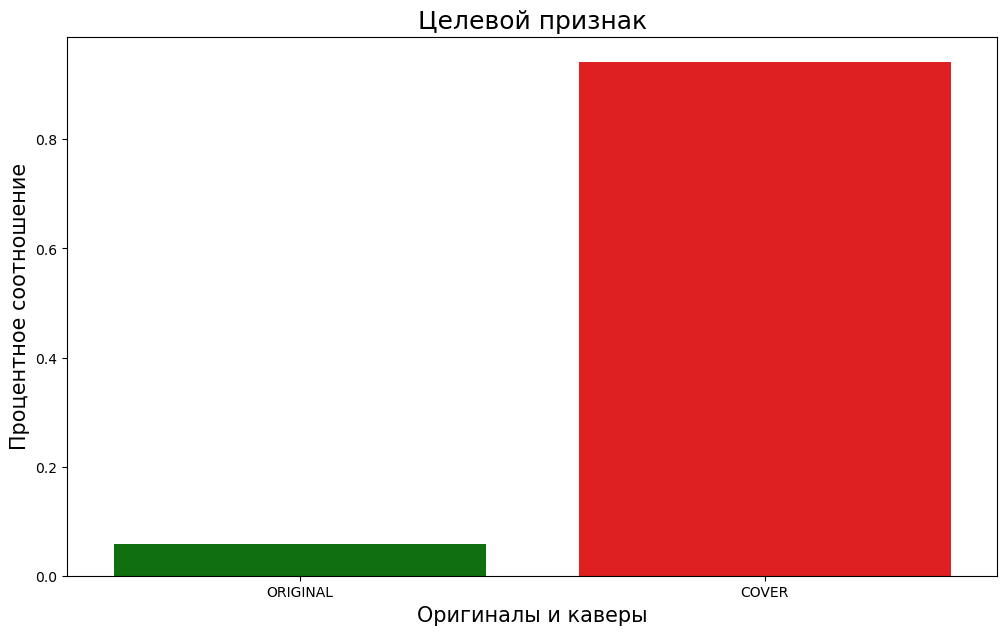

Обработка завершена


In [26]:
data = preprocess_dataset(data=data)

**Информация по датасету**

In [27]:
display_dataset_info(data)

-----------------------------------SAMPLE-----------------------------------


,isrc,title,genres,year,language_text,dttm,duration,text,track_remake_type
0,USFI86900049,Proud Mary,"ROCK, ALLROCK",1969,EN,1.257973e+12,187220.0,left a good job in the city workin' for the man ev'ry night and day and i never lost one minute ...,1
2,USFI86900065,Fortunate Son,"ROCK, ALLROCK",1969,EN,1.257973e+12,137780.0,some folks are born made to wave the flag ooh they're red white and blue and when the band plays...,1
3,USUL10400965,La Camisa Negra,"POP, FOLK, LATINFOLK",2004,ES,1.253563e+12,216840.0,uno por pobre y feo hombre pero antoja'o ay ome tengo la camisa negra hoy mi amor está de luto h...,1
4,USUM70722806,The Way I Are,"FOREIGNRAP, RAP",2007,EN,1.258405e+12,179660.0,yeah yeah remember the time baby yeah i ain't got no money i ain't got no car to take you on a d...,1
8,FR8Q10900116,Extraball,ELECTRONICS,2009,EN,1.253218e+12,212620.0,now i try to walk and talk i need the extraball it's purely physical i think your time is now i ...,0



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71115 entries, 0 to 72570
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   isrc               71115 non-null  category
 1   title              71115 non-null  category
 2   genres             71115 non-null  category
 3   year               71115 non-null  category
 4   language_text      71115 non-null  category
 5   dttm               71115 non-null  float64 
 6   duration           71115 non-null  float64 
 7   text               71115 non-null  object  
 8   track_remake_type  71115 non-null  int64   
dtypes: category(5), float64(2), int64(1), object(1)
memory usage: 7.5+ MB


None

----------------------------------DESCRIBE----------------------------------


,isrc,title,genres,year,language_text,dttm,duration,text,track_remake_type
count,71115,71115,71115,71115.0,71115,7.111500e+04,7.111500e+04,71115,71115.000000
unique,71115,45175,229,77.0,52,NaN,NaN,40248,NaN
top,AEA0D1828626,Morena,"FOLK, LATINFOLK",2021.0,EN,NaN,NaN,no text,NaN
freq,1,81,18381,24976.0,33537,NaN,NaN,3095,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.584904e+12,2.048968e+05,NaN,0.059003
std,NaN,NaN,NaN,NaN,NaN,9.077109e+10,8.570279e+04,NaN,0.235632
min,NaN,NaN,NaN,NaN,NaN,1.249926e+12,0.000000e+00,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,1.572515e+12,1.612300e+05,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,1.620641e+12,1.993200e+05,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,1.637160e+12,2.390450e+05,NaN,0.000000


<div style="border:solid green 2px; padding: 20px">
    
*Точка сохранения №2. Сохранение финального датасета.* 

**Сохранение финального датасета**

In [28]:
data.to_pickle(os.path.join(work_dir, "data_final"), compression="zip")

<div style="border:solid green 2px; padding: 20px">
    
*Точка восстановления №2. Загрузка финального датасета.*

**Сбор мусора**

In [29]:
gc.collect()

2729

**Загрузка финального датасета**

In [30]:
data = pd.read_pickle(os.path.join(work_dir, "data_final"), compression="zip")

## Классификационная модель 

**Инициализация модели**

<div style="border:solid green 2px; padding: 20px">
    
*Гиперпараметры модели были подобраны с помощью `GridSearchCV` с кроссвалидацией. Для сокращения времени гиперпараметры прописываем непосредственно в модель*
    
*Т.к в датасете присутствую дисбаланс классов, в качестве метрики выбрана `ROC-AUC`, как наименее критичная к дисбалансу классов.*     

In [31]:
lgbm_final = LGBMClassifier(objective='binary',
                            boosting_type="gbdt",
                            max_depth=12,
                            learning_rate=0.1,
                            n_estimators=100,
                            num_leaves=45,
                            min_child_samples=45,
                            min_child_weight=10,
                            min_split_gain=0.3,
                            reg_alpha=0.1,
                            is_unbalance=True,
                            random_state=RANDOM,
                            verbose=-1,
                            n_jobs=-1)

**Предсказание модели, выборки и сама модель (вызов функции `get_model_predictions`)**

In [32]:
features_train, features_test, target_train, target_test, predicted_probalities_test = get_model_predictions(
    data=data, model=lgbm_final, is_valid=False)

Тренировочная выборка:  (56892, 8) (56892,)
Тестовая выборка:  (14223, 8) (14223,)
Модель LGBMClassifier обучена.
Усредненная метрика AUC-ROC модели на тренировочной выборке с кроссвалиидацией: 0.9763
Метрика AUC-ROC модели на тестовой выборке: 0.9775


**Создаем матрицу ошибок.**

In [33]:
conf_matrix = confusion_matrix(target_test, lgbm_final.predict(features_test))

**Выводим матрицу на экран (вызов функции `drow_confusion_matrix`).**

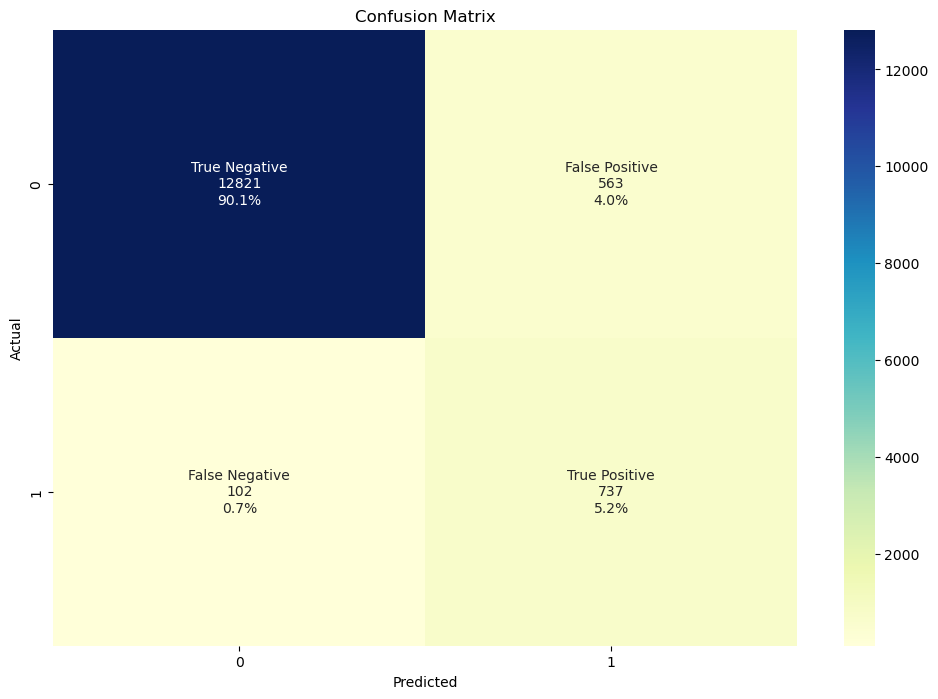

In [34]:
drow_confusion_matrix(conf_matrix)

**Результат (вызов функции `conf_matrix_result`).**

In [35]:
conf_matrix_result(conf_matrix)

Всего предсказаний: 14223
Правильно предсказанные ответы (Accuracy): 0.9532
Ошибки в прогнозах: 0.0468
Recall: 0.8784
Precision: 0.5669
FN/TP: 0.14
FP/TN: 0.04


Что в итоге:

Выборки на трейн и тест разбиты в соотношении **80** на **20**.

Метрика `AUC-ROC` на тестовой выборке около **0.98**.

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:
   
   - **TN** в левом верхнем углу. 12821 правильных ответов. Кавер определен правильно.
   - **TP** в правом нижнем углу. 737 правильных ответов. Оригинал определен правильно.

2. Вне главной диагонали — ошибочные варианты:

   - **FP** в правом верхнем углу. 563 ошибок ошибочных предсказаний первого рода. Кавер определен как оригинал. 
   - **FN** в левом нижнем углу. 102 ошибочных предсказаний второго рода. Оригинал определен как кавер.
   

Метрика `Recall` получилась 87.84%,  `Precision` - 56.56%. 

**PR-кривая.**

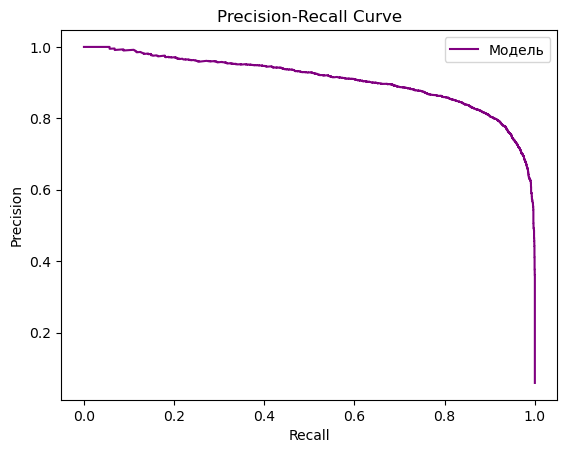

In [36]:
drow_pr_curve(features_train, target_train, lgbm_final, treshold=False)

**Сбор мусора**

In [37]:
gc.collect()

8571

## Модель нахождения кавер-треков и/или исходников к заданному треку в датасете

В модуле SentenceTransformer есть предобученная модель `sentence-transformers/LaBSE`, которая воспринимает много языков и создаёт эмбединги так, что при сравнении например одного слова на разных языках вектора этих слов будут максимально близки.

[LaBSE](https://huggingface.co/sentence-transformers/LaBSE)

В поиске кавер-треков и/или исходников к заданному треку в датасете будут использованы след. методы.

- получение эмбеддингов по всем текстам песен в датасете,
- по имени трека, получение эмбеддинга текста песни,
- проведение семантического анализа ветора текста песни со всеми векторами песен в датасете,
- выбор текстов с наибольшей семантической близостью,
- проведение классификаци кавер/оригинал,
- вывод списка кавер/оригинал,
- поиск оригинала, его нет в списке.

**Провека наличия `GPU`**

In [38]:
# проверяем наличие gpu
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

**Инициализация модели**

In [39]:
model = SentenceTransformer('sentence-transformers/LaBSE')

**Векторизация**

<div style="border:solid green 2px; padding: 20px">
    
*Данный этап можно пропустить, т.к эмбеддинги делаются долго  и их можно загрузить ниже из pickle файла.
 Ячейки с кодом закомментированы, чтобы случайно не начать создание эмбеддингов в случае `RUN ALL`* 

In [40]:
# embedding_all_texts = model.encode(list(data["text"]),
#                                    show_progress_bar=True,
#                                    device=device,
#                                    batch_size=4)

<div style="border:solid green 2px; padding: 20px">
    
*Точка сохранения №3. Сохранение векторов текстов песен.* 

**Сохранение эмбеддингов**

In [41]:
# with open(os.path.join(work_dir, "embedding_all_texts.pickle"), "wb") as file:
#     pickle.dump(embedding_all_texts, file)

**Сбор мусора и очистка кэша `CUDA`**

In [42]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

<div style="border:solid green 2px; padding: 20px">
    
*Точка восстановления №3. Загрузка векторов текстов песен.*

**Загрузка эмбеддингов**

In [43]:
with open(os.path.join(work_dir, "embedding_all_texts.pickle"), "rb") as file:
    embedding_all_texts = pickle.load(file)

In [44]:
embedding_all_texts.shape

(71115, 768)

**Проверка работы функции `search_covers` для разных треков**

В имеющейся базе данных найдено 4 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - QZHZ62144078, Название - Oops I Did It Again, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 2: Код isrc - QZHZ62113597, Название - Oops I Did It Again, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - GBKPL2149328, Название - Oops!...I Did It Again, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 4: Код isrc - UK6KW2100211, Название - Oops!... I Did It Again, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

В имеющейся базе данных нет оригинала трека.
Возможный оригинал будет взят с сайта https

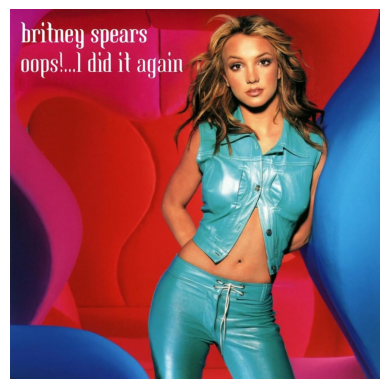

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [45]:
search_covers(song_name="Oops I Did It Again",
              embedding_all_texts=embedding_all_texts,
              device=device,
              model_trasformer=model,
              model_predictor=lgbm_final,
              dataset=data)

В имеющейся базе данных найдено 2 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - SEBKB9802010, Название - My Favourite Game, Исполнитель - The Cardigans
Тип песни - ORIGINAL, Тип предсказанный моделью - COVER
Модель ошибочно классифицировала тип трека.

Трек 2: Код isrc - US94P1414009, Название - My Favourite Game, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - ORIGINAL
Модель ошибочно классифицировала тип трека.

В имеющейся базе данных есть оригинал трека.

Информациою по оригиналу можно взять с сайта https://genius.com

Searching for "My Favourite Game"...
Done.
Исполнитель: The Cardigans. Трек: My Favourite Game


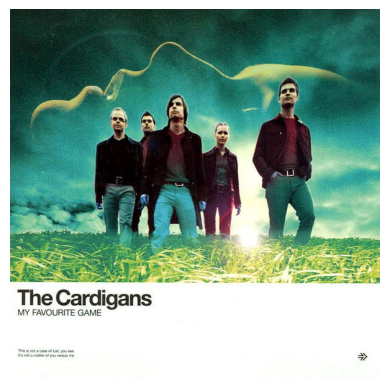

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [46]:
search_covers(song_name="My Favourite Game",
              embedding_all_texts=embedding_all_texts,
              device=device,
              model_trasformer=model,
              model_predictor=lgbm_final,
              dataset=data)

В имеющейся базе данных найдено 10 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - USPG19090037, Название - Wind Of Change, Исполнитель - Scorpions
Тип песни - ORIGINAL, Тип предсказанный моделью - COVER
Модель ошибочно классифицировала тип трека.

Трек 2: Код isrc - PLS921752475, Название - Wind of Change, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - PLS921752603, Название - Wind of Change, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 4: Код isrc - PLS921752564, Название - Wind of Change, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 5: Код isrc - AUBEC1990310, Название - Wind Of Change, Исполнитель - Unknown
Тип песни - COVER, Тип предс

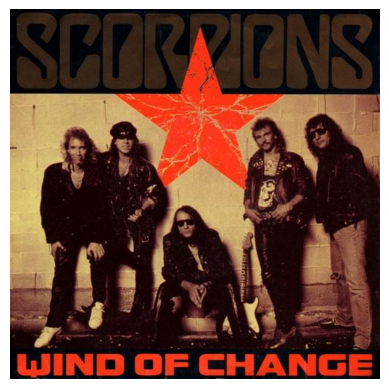

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [47]:
search_covers(song_name="Wind Of Change",
              embedding_all_texts=embedding_all_texts,
              device=device,
              model_trasformer=model,
              model_predictor=lgbm_final,
              dataset=data)

В имеющейся базе данных найдено 3 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - ITTY52000007, Название - California Dreaming, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 2: Код isrc - USF096600390, Название - California Dreaming, Исполнитель - Wes Montgomery
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - USLZJ1694103, Название - California Dreaming, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - ORIGINAL
Модель ошибочно классифицировала тип трека.

В имеющейся базе данных нет оригинала трека.
Возможный оригинал будет взят с сайта https://genius.com

Searching for "California Dreaming"...
Done.
Исполнитель: Arman Cekin. Трек: California Dreaming


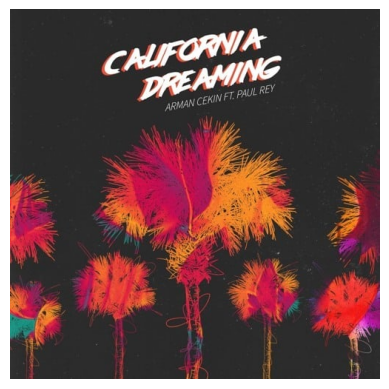

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [48]:
search_covers(song_name="California Dreaming",
              embedding_all_texts=embedding_all_texts,
              device=device,
              model_trasformer=model,
              model_predictor=lgbm_final,
              dataset=data)

В имеющейся базе данных найдено 5 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - GBF089190020, Название - Nothing Else Matters, Исполнитель - Metallica
Тип песни - ORIGINAL, Тип предсказанный моделью - ORIGINAL
Модель правильно классифицировала тип трека.

Трек 2: Код isrc - QMKHM1900102, Название - Nothing Else Matters, Исполнитель - Metallica
Тип песни - ORIGINAL, Тип предсказанный моделью - ORIGINAL
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - USA560693025, Название - Nothing Else Matters, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 4: Код isrc - USA370581399, Название - Nothing Else Matters, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 5: Код isrc - QMKHM2100037, Название - Nothing Else Matters, Исполните

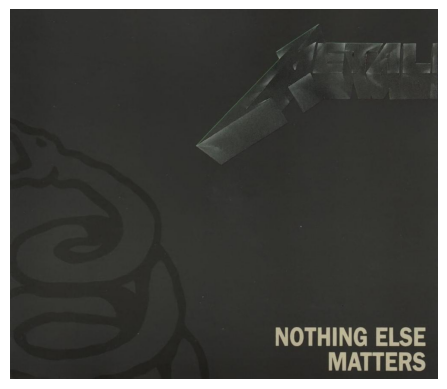

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [49]:
search_covers(song_name="Nothing Else Matters",
              embedding_all_texts=embedding_all_texts,
              device=device,
              model_trasformer=model,
              model_predictor=lgbm_final,
              dataset=data)

## Выводы

В результате исследования были построены 2 модели:

- модель классификации,
- модель нахождения кавер-треков и/или исходников к заданному треку в датасете.

Классификация проводилась на основе метаданных. 

Итоговая метрика около 0.98. 

Модель нахождения кавер-треков и/или исходников к заданному треку находит задынный трек и выводит список нужных треков.

К сожаленю не все данные удалость вытащить из открытых источников, т.к. из там либо нету, либо доступ закрыт, либо они платные. 